# Monocular depth estimation using a single image

from this tutorial https://huggingface.co/docs/transformers/tasks/monocular_depth_estimation


In [1]:
from transformers import pipeline
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean

# checkpoint = "vinvino02/glpn-nyu"
checkpoint = "Onegafer/glpn-nyu-finetuned-diode-230603-102021"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

2023-08-22 11:10:54.887114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 11:10:56.166711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-22 11:10:56.166843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-22 11:10:56.166854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

(3840, 2160)
(640, 360)


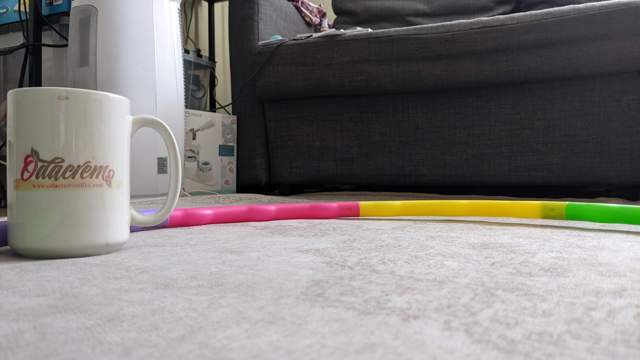

In [2]:
from PIL import Image, ImageOps
import requests

# filename = "pics/marcos.jpg"# "/Users/stadmin/Documents/anyObject/img/test3/48.jpg"
filename = "mugOnCarpet/PXL_20230713_184129417.jpg"
img0 = Image.open(filename)
print(img0.size)
img1 = ImageOps.contain(img0, (640,640)).convert('RGB')
print(img1.size)
pixel_values = image_processor(img1, return_tensors="pt").pixel_values
img1

torch.Size([352, 640])
max depth tensor(6.1301) min depth tensor(0.4091)


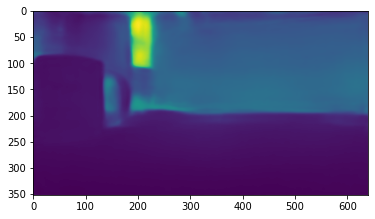

In [3]:
import torch

with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth
    print(predicted_depth[0].shape)
print('max depth', predicted_depth.max(), 'min depth', predicted_depth.min())
plt.imshow(predicted_depth[0].cpu().numpy())

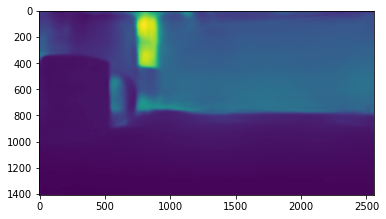

In [4]:
import numpy as np

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    scale_factor=4,
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()

formatted = (output * 255 / np.max(output)).astype("uint8")

plt.imshow(formatted)

In [5]:
import ipyvolume as ipv

# project depth out to points in 3D space
w = predicted_depth.shape[2]
h = predicted_depth.shape[1]
pixelCoords = np.zeros((h,w,3))

print(predicted_depth[0].shape)
zmin = predicted_depth[0].min()
zmax = predicted_depth[0].max()
for i in np.arange(h):
    for j in np.arange(w):
        z = (predicted_depth[0,i,j] - zmin)  / (zmax - zmin) 
        pixelCoords[i,j,0] = j/(w) 
        pixelCoords[i,j,1] = i/(h) 
        pixelCoords[i,j,2] = z

xcoords = pixelCoords[:,:,0]
ycoords = pixelCoords[:,:,1]
coords = pixelCoords[:,:,2]

ipv.figure()
m = ipv.plot_mesh(x=xcoords, y=ycoords, z=coords, wireframe=False)
ipv.squarelim()
ipv.show()


torch.Size([352, 640])


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…